In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color='#384152' # 실행창의 색깔
sns.set(rc={'axes.facecolor':color, 'figure.facecolor':color})

import logging
import os

import time
import datetime
import locale
import logging
import os
import platform

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import sklearn.metrics as met
import time

In [2]:
def get_MACD(df, short_ma=12, long_ma=26, signal_period=9):
    ewm_12 = df['close'].ewm(span = short_ma, min_periods = short_ma - 1).mean()
    ewm_26 = df['close'].ewm(span = long_ma, min_periods = long_ma - 1).mean()
    df['MACD'] = ewm_12 - ewm_26
    df['MACDSignal'] = df['MACD'].ewm(span = signal_period, min_periods = signal_period-1).mean()
    df['MACDDiff'] = df['MACD'] - df['MACDSignal']
    return df

def get_Stochastic(df, n=14):
    df['sto_K_{}'.format(n)] = 100 * ((df.close - df.low.rolling(n).min()) / 
                                      (df.high.rolling(n).max() - df.low.rolling(n).min()))
    df['sto_D_{}'.format(n)] = df['sto_K_{}'.format(n)].rolling(3).mean()
    return df

def get_RSI(df, n=14):
    U = np.where(df['close'].diff(1)>0, df['close'].diff(1), 0)
    D = np.where(df['close'].diff(1)<0, df['close'].diff(1)*(-1), 0)

    AU = pd.Series(U).rolling(window=n, min_periods=n).mean()
    AD = pd.Series(D).rolling(window=n, min_periods=n).mean()

    RSI = AU.div(AD+AU) * 100
    df['RSI_{}'.format(n)] = RSI.values
    return df

def get_RoC(df, periods):
    df['roc_{}'.format(periods)] = df['close'].pct_change(periods=periods)
    return df

def get_CV(df, window):
    df['his_vol_{}'.format(window)] = np.log(df['close'] / df['close'].shift(1)).rolling(window).std()*(252**0.5)
    return df

def get_WilliamR(df, n):
    W_R = -100 * ((df.high.rolling(n).max() - df.close) / (df.high.rolling(n).max() - df.low.rolling(n).min()))
    df['WR_{}'.format(n)] = W_R
    return df

def get_CCI(df, window):
    TP = (df.close + df.low + df.high) / 3
    dataX = []
    for i in range(len(TP) - window+1):
        a = TP.values[i:(i+window)]
        dataX.append(a)
    dataMean = [i.mean() for i in dataX]
    AVEDEV = [abs(x - mean).mean() for x, mean 
              in zip(dataX, dataMean)]
    for i in range(window-1):
        AVEDEV.insert(0,np.nan)
    AVEDEV = pd.Series(AVEDEV, index = TP.index)
    CCI = (TP - TP.rolling(20).mean()) / (0.015 * AVEDEV)
    df['CCI_{}'.format(window)] = CCI
    return df

def get_DI(df, window):
    df['DI_{}'.format(window)] = 100 * ((df.close - df.close.rolling(window).mean()) / df.close.rolling(window).mean())
    return df

In [3]:
# data_manager.py

def load_chart_data(fpath):
    chart_data = pd.read_csv(fpath, thousands=',')
    return chart_data

def preprocess(chart_data, windows):
    prep_data = chart_data
    for window in windows:
        prep_data['close_ma{}'.format(window)] = prep_data['close'].rolling(window).mean()
        prep_data['volume_ma{}'.format(window)] = (
            prep_data['volume'].rolling(window).mean())
    return prep_data, len(prep_data.columns)

def build_training_data(prep_data):
    training_data = prep_data
    for window in range(12, 91):
        training_data = get_CV(training_data, window)
    for periods in range(1, 11):
        training_data = get_RoC(training_data, periods)
    for n in range(3, 91):
        training_data = get_RSI(training_data, n)
        training_data = get_Stochastic(training_data, n)
        training_data = get_WilliamR(training_data, n)
    training_data = get_CCI(training_data, 20)
    for window in [5,10]:
        training_data = get_DI(training_data, window)
    training_data = get_MACD(training_data)
    return training_data

def make_target(df, use_fn='f', period=1, window=1, 
                method='regress', thresh=.02):
    y_df = pd.DataFrame(index=df.index)
    f = lambda x, i : np.log(x.shift(-1 * i) / x)
    g = lambda x, i, j : np.log(x.shift(-1 * i) / x.rolling(j).mean())
    if window > 99:
        target = 'sh{:02}_Y_{:03}'.format(period, window)
    else:
        target = 'sh{:02}_Y_{:02}'.format(period, window)
    target = target[:6] if use_fn=='f' else target
    y_df[target] = \
            f(df['close'], period) if use_fn == 'f' else g(df['close'], period, window)
    if method != 'regress':
        y_df[target] = np.where(
            y_df[target] > thresh, 1, np.where(
                y_df[target] < (-1 * thresh), -1, 0))
    return y_df

In [4]:
def concat_x_y(df, period, window, n_col=0,
               use_fn='f', thresh=.02, method='regress'):
    y_df = make_target(df, use_fn=use_fn, period=period, window=window, 
                           thresh=thresh, method=method)
    y = y_df.columns[0]
    compact_df = pd.concat((df, y_df), axis=1)
#     compact_df = compact_df[compact_df.columns[n_col:]]
#     compact_df = compact_df.dropna()
    return compact_df, y

def train_test_split(compact_df, start, end):
    train = compact_df[(compact_df['date'] >= start) &
                   (compact_df['date'] <= end)]
    test = compact_df[compact_df['date'] >= \
                (pd.Timestamp(end) + pd.Timedelta('1 days')).strftime('%Y-%m-%d')]
    train, test = train.dropna(), test.dropna()
    return train, test

def correl_selection(df, y, corr_li):
    col_set = {}
    for col_name in corr_li:
        corr_ = abs(
            df[
                [col for col in df 
                 if (col.find(col_name) != -1)|(col.find(y) != -1)]
            ].corr()[y]
        ).sort_values(ascending=False)
        col_set[corr_.index[1]] = corr_.iloc[1]
    return col_set

#### main.py

In [37]:
start_time, check_point = time.time(), 0
print('#1 Generate Feature & Target and Correlation Selection\n')
print('#2 Max Precision Filter')
print(' - 각 예측 기간별 Time window에 대하여 Max Precision을 측정 및 선별)\n')

stock_code = '005930'
chart_data = load_chart_data('./stock_data/{}.csv'.format(stock_code))
prepare_y_dict = {}

windows = [i for i in range(1, 90)]
prep_data, n_col = preprocess(chart_data, windows=windows)
training_data = build_training_data(prep_data)
del prep_data

features_chart_data = ['date', 'open', 'high', 'low', 'close', 'volume']
chart_data = training_data[features_chart_data]

thresh = .02 # Use only method=='Classification'
# periods = [i for i in range(1, 91)]
# windows = [i for i in range(1, 91, 3)]
periods = [1, 5, 10, 20, 30, 40, 50, 60]
windows = [i for i in range(1, 91, 3)]
corr_li = ['sto_K','sto_D','RSI','roc','his_vol','WR',
                 'CCI','DI','MACD','MACDSignal','MACDDiff']
start, end = '2007-01-01', '2017-12-31' # 훈련시킬 기간
for period in periods:
    pred_n = 'pred_{:02}'.format(period)
    print(pred_n + ' : (max precision 갱신 시 message 출력)')
    _prepare = {}
    max_precision, max_prec_day, rmse = 0, 0, 0
    compact_df, comp_y = concat_x_y(training_data, period=period, window=1, 
                               n_col=n_col, use_fn='f', 
                               thresh=thresh, method='regress')
    train, test = train_test_split(compact_df, start, end)
    col_set = correl_selection(train, y=comp_y, corr_li=corr_li)
#     y_valid = np.where(train[comp_y].values > 0, 1, 0)
    y_valid = train[comp_y].values
    comp_y_tuple = (train, test, col_set)
    for window in windows:
        compact_df, y = concat_x_y(training_data, period=period, window=window, 
                                   n_col=n_col, use_fn='g', 
                                   thresh=thresh, method='regress')
        train, test = train_test_split(compact_df, start, end)
        col_set = correl_selection(train, y=y, corr_li=corr_li)
        n_cv = 5
        ix_cv = int(len(train) / n_cv)
        precision = 0
        for i in [0,1,2,3]:
            X_train = train[list(col_set.keys())].iloc[i*ix_cv:(i+1)*ix_cv]
            y_train = train[y].iloc[i*ix_cv:(i+1)*ix_cv]
            X_valid = train[list(col_set.keys())].iloc[(i+1)*ix_cv:(i+2)*ix_cv]
            y_true = y_valid[(i+1)*ix_cv:(i+2)*ix_cv]

            xgb_reg = xgb.XGBRegressor(
                 learning_rate =0.15,
                 n_estimators=100,
                 max_depth=5,
                 min_child_weight=2,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 nthread=4,
                 scale_pos_weight=1,
                 seed=27,
                 eval_metric='map')
            xgb_reg.fit(X_train, y_train)
        
#             y_pred = np.where(xgb_reg.predict(X_valid) > 0, 1, 0)
            y_pred = xgb_reg.predict(X_valid)
            precision += met.precision_score(
                                np.where(y_true>0, 1, 0), 
                                np.where(y_pred>0, 1, 0))
            rmse += met.mean_squared_error(y_true, y_pred) ** .5
        precision = precision / (n_cv - 1)
        rmse = rmse / (n_cv - 1)
        if (precision > max_precision) & (rmse <= 0.01 * (period ** .3)):
            max_prec_day = y[-2:]
            max_precision = precision
            argmax_rmse = rmse
            tot_time = time.time() - start_time
#             print('\t{} : {:.2%}, rmse={:.2%}'.format(y, max_precision, argmax_rmse), end='')
#             print('\telapse:{:.2f} sec, TOT:{:.2f} min'.format(
#                 tot_time-check_point, tot_time / 60))
#             check_point = tot_time
        print('\t{} : {:.2%}, rmse={:.2%}'.format(y, precision, rmse), end='')
        print('\telapse:{:.2f} sec, TOT:{:.2f} min'.format(
            tot_time-check_point, tot_time / 60))
        check_point = tot_time
#         _prepare[y] = (train, test, col_set)
#     if max_precision == 0:
#         print('\t이 예측은 사용할 수 없습니다.')
#         continue
#     print('\tmax_precision_day : {}\n\tmax_precision : {:.2%}'.format(max_prec_day, max_precision))
#     train, test, col_set = _prepare[y[:-2]+max_prec_day]
#     prepare_y_dict[pred_n] = {comp_y : comp_y_tuple,
#                               y : (train, test, col_set, max_prec_day, max_precision)}
#     tot_time = time.time() - start_time
#     print("\tDone '" + pred_n + "'\t\telapse:{:.2f} sec, TOT:{:.2f} min".format(
#                 tot_time - check_point, tot_time / 60))
#     check_point = tot_time

#1 Generate Feature & Target and Correlation Selection

#2 Max Precision Filter
 - 각 예측 기간별 Time window에 대하여 Max Precision을 측정 및 선별)

pred_01 : (max precision 갱신 시 message 출력)
	sh01_Y_01 : 52.91%, rmse=2.00%	elapse:2.54 sec, TOT:0.04 min
	sh01_Y_04 : 50.10%, rmse=2.90%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_07 : 48.39%, rmse=3.54%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_10 : 49.31%, rmse=4.01%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_13 : 48.29%, rmse=4.56%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_16 : 49.70%, rmse=5.00%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_19 : 49.97%, rmse=5.41%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_22 : 49.54%, rmse=5.82%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_25 : 50.20%, rmse=6.14%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_28 : 50.13%, rmse=6.53%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_31 : 50.08%, rmse=6.92%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_34 : 51.33%, rmse=7.31%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_37 : 51.22%, rmse=7.79%	elapse:0.00 sec, TOT:0.04 min
	sh01_Y_40 : 51.24

	sh30_Y_19 : 65.46%, rmse=15.06%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_22 : 64.52%, rmse=15.30%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_25 : 66.89%, rmse=15.37%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_28 : 67.78%, rmse=15.54%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_31 : 66.55%, rmse=15.71%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_34 : 66.36%, rmse=15.82%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_37 : 66.12%, rmse=16.04%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_40 : 67.08%, rmse=16.18%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_43 : 67.56%, rmse=16.22%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_46 : 64.52%, rmse=16.16%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_49 : 65.09%, rmse=16.29%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_52 : 64.78%, rmse=16.25%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_55 : 64.36%, rmse=16.55%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_58 : 64.70%, rmse=16.69%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_61 : 64.41%, rmse=16.82%	elapse:0.00 sec, TOT:0.04 min
	sh30_Y_64 : 64.03%, rmse=16.95%	elapse:0.00 sec, TOT:0

In [35]:
met.mean_squared_error(y_true, y_pred) ** .5

0.03397012884656872

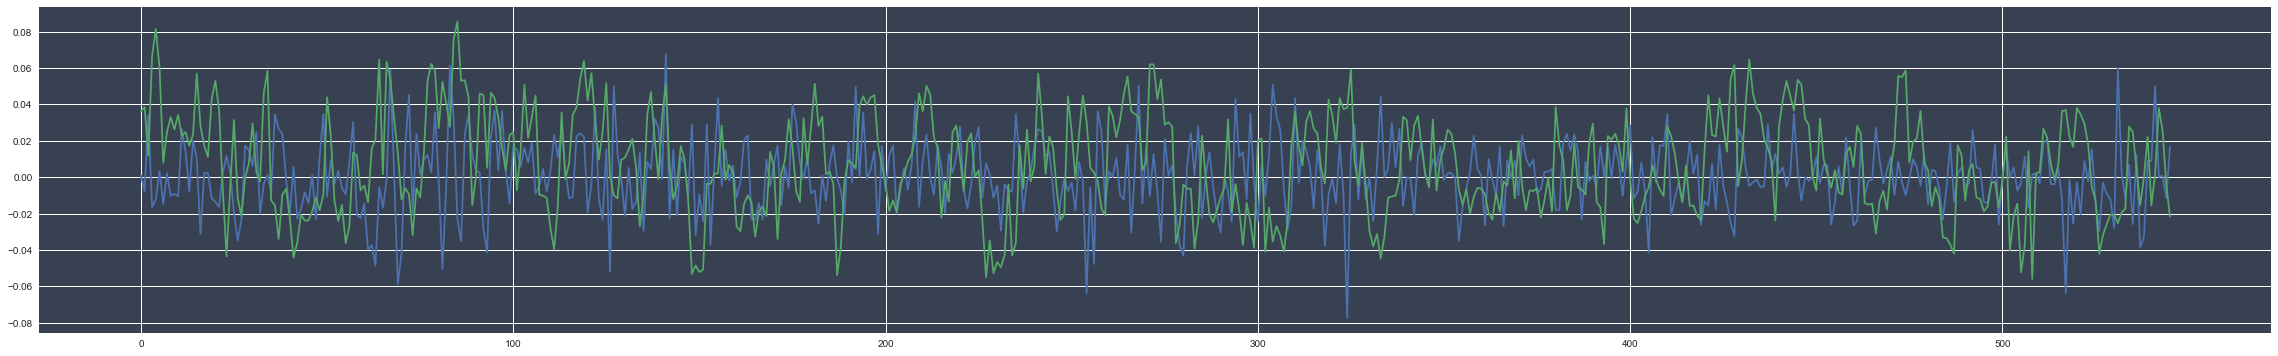

In [33]:
plt.figure(figsize=(40,6))
plt.plot(y_true)
plt.plot(y_pred)

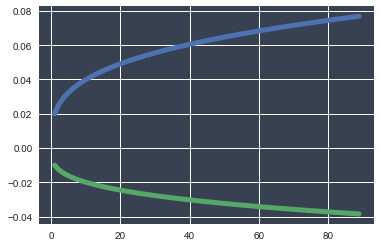

In [20]:
plt.plot(np.arange(1, 90), np.arange(1, 90) ** .3 * .02, linewidth=5)
plt.plot(np.arange(1, 90), np.arange(1, 90) ** .3 * .01 * -1, linewidth=5)

In [ ]:
# Train에서 각기 투자 Simulation을 진행
